# A Causal Analysis of Success in Modern Society

## Tutorial: Talent, Luck, and Causal Inference

Author: Krishna Kishore Buddi  
Course: MSML610  
Instructor: Prof. Giovanni Saggese  
Institution: University of Maryland

---

## What this notebook does

This notebook walks through the entire analysis pipeline for the project *“A Causal Analysis of Success in Modern Society.”*  
You will:

- simulate a population of agents with different talents,
- expose them to good and bad events that compound over time,
- measure how unequal the final outcomes become,
- and use modern causal inference tools (Double Machine Learning and Causal Forests) to separate **talent** from **luck**.

The goal is not to perfectly model the real world. Instead, the goal is to understand a simple but powerful mechanism:

> If abilities are roughly “normal” but success is extremely unequal, then **random multiplicative events** must be doing a lot of the work.

This notebook is meant to be **interactive**:

- Run each section in order.
- Look at the printed summaries and plots.
- Then tweak parameters (number of agents, number of events, event magnitudes) and see what changes.

For a higher-level narrative and more theory:
- See `README.md` for the big-picture motivation and results.
- See `causal_success_tutorial.md` for a detailed written tutorial.
- See `causal_success_API.md` for function-level documentation of `causal_success_utils.py`.


## Section 1: Environment Setup and Package Imports

We start by setting up the Python environment and importing the core libraries used throughout the tutorial. NumPy handles numerical computations, Pandas provides tools for working with tabular data, and Matplotlib/Seaborn support visualization. For the causal analysis, we rely on scikit-learn for general machine learning routines and EconML for modern double machine learning and causal forest estimators.

This section simply ensures that all dependencies are available and configured, so the later parts of the notebook can focus on the model, the simulation, and the interpretation of results rather than on technical setup detals.


In [1]:
import os
import sys

# Make sure the project root is importable (works in Docker and locally)
PROJECT_ROOT = "/app" if os.path.exists("/app") else os.getcwd()
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from tqdm import tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from econml.dml import LinearDML, CausalForestDML

# Reload the utils module to pick up any local changes during development
import importlib
import causal_success_utils
importlib.reload(causal_success_utils)

# Import everything the notebook uses from the utils module
from causal_success_utils import (
    Agent,
    create_population,
    run_simulation,
    calculate_gini,
    get_results_dataframe,
    generate_summary_statistics,
    validate_simulation_results,
    run_policy_simulation,
)

np.random.seed(42)
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (14, 6)
plt.rcParams["font.size"] = 10

print("Environment configured successfully")
print(f"Project root: {PROJECT_ROOT}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Python executable: {sys.executable}")
print("causal_success_utils module imported successfully")

Environment configured successfully
Project root: /app
NumPy version: 1.24.3
Pandas version: 2.0.3
Python executable: /usr/local/bin/python
causal_success_utils module imported successfully


In [2]:
# Experimental Configuration

# Population parameters
N_AGENTS = 100           # Number of agents in the simulation

# Time parameters
N_ROUNDS = 200           # Number of time steps (periods)

# Event parameters
LUCKY_EVENTS_PER_ROUND = 10
UNLUCKY_EVENTS_PER_ROUND = 10
EVENTS_PER_ROUND = LUCKY_EVENTS_PER_ROUND + UNLUCKY_EVENTS_PER_ROUND

# Event impact parameters
# Lucky events: on average +35% with moderate spread
LUCKY_MEAN = 0.35
LUCKY_STD = 0.12

# Unlucky events: on average -10% with smaller spread
UNLUCKY_MEAN = 0.10
UNLUCKY_STD = 0.04

# Random seed for reproducibility
RANDOM_SEED = 42

print("Experimental configuration loaded")
print(f"  Agents: {N_AGENTS}")
print(f"  Rounds: {N_ROUNDS}")
print(f"  Events per round: {EVENTS_PER_ROUND}")
print(f"  Random seed: {RANDOM_SEED}")

Experimental configuration loaded
  Agents: 100
  Rounds: 200
  Events per round: 20
  Random seed: 42


In [3]:
# ===============================
# Re-run simulation using config
# ===============================

# Safety check: ensure configuration cell has been run
assert "N_AGENTS" in globals(), "Experimental configuration cell was not run."
assert "RANDOM_SEED" in globals(), "Experimental configuration cell was not run."

# 1) Build population using the configured number of agents and seed
agents = create_population(n_agents=N_AGENTS, seed=RANDOM_SEED)

# 2) Run simulation using ONLY the config values defined above
agents = run_simulation(
    agents=agents,
    n_periods=N_ROUNDS,
    n_lucky_events_per_period=LUCKY_EVENTS_PER_ROUND,
    n_unlucky_events_per_period=UNLUCKY_EVENTS_PER_ROUND,
    lucky_mean=LUCKY_MEAN,
    lucky_std=LUCKY_STD,
    unlucky_mean=UNLUCKY_MEAN,
    unlucky_std=UNLUCKY_STD,
    seed=RANDOM_SEED,
    verbose=True,
)

# 3) Create results dataframe and derived quantities
df_results = get_results_dataframe(agents)
df_results["log_capital"] = np.log(df_results["capital"])

# Inequality metrics
gini = calculate_gini(df_results["capital"].values)
top10_share = (
    df_results.nlargest(max(1, len(df_results) // 10), "capital")["capital"].sum()
    / df_results["capital"].sum()
)
top20_share = (
    df_results.nlargest(max(1, len(df_results) // 5), "capital")["capital"].sum()
    / df_results["capital"].sum()
)
cap_range = df_results["capital"].max() / df_results["capital"].min()

# Correlations: talent vs outcomes and luck vs outcomes
talent_corr = df_results["talent_norm"].corr(df_results["log_capital"])
luck_corr = df_results["lucky_events"].corr(df_results["log_capital"])
relative_strength = abs(luck_corr) / max(abs(talent_corr), 1e-12)

# 4) Top performers summary
top_n = 10
top_df = df_results.nlargest(top_n, "capital").copy()

# Rank talent so rank=1 is highest talent
df_results["talent_rank"] = df_results["talent_norm"].rank(ascending=False)

avg_top_talent_rank = (
    top_df.merge(df_results[["id", "talent_rank"]], on="id")["talent_rank"].mean()
)
avg_pop_talent_rank = df_results["talent_rank"].mean()

avg_top_lucky = top_df["lucky_events"].mean()
avg_pop_lucky = df_results["lucky_events"].mean()

print("Simulation rerun completed with configured parameters.")
print(f"  Gini coefficient:       {gini:.4f}")
print(f"  Top 10% wealth share:   {top10_share:.3f}")
print(f"  Top 20% wealth share:   {top20_share:.3f}")
print(f"  Capital range (max/min): {cap_range:.1f}x")
print(f"  Corr(talent, log capital): {talent_corr:.3f}")
print(f"  Corr(lucky events, log capital): {luck_corr:.3f}")
print(f"  Relative strength |luck|/|talent|: {relative_strength:.2f}x")

Running simulation: 100%|████████████████████████████████████████████████████████| 200/200 [00:00<00:00, 356.09period/s]

Simulation rerun completed with configured parameters.
  Gini coefficient:       0.7071
  Top 10% wealth share:   0.599
  Top 20% wealth share:   0.762
  Capital range (max/min): 293.6x
  Corr(talent, log capital): 0.435
  Corr(lucky events, log capital): 0.871
  Relative strength |luck|/|talent|: 2.00x


## Section 2: Theoretical Framework

In this section we spell out the model that drives the simulation: how we represent “talent,” how random events affect people over time, and how we frame the causal question about luck and success.

---

### 2.1 Model Specification

Each agent \(i\) is described by a talent vector \(T_i\) with several components. These dimensions are not meant to be perfect psychological constructs, but convenient knobs that capture different ways people can be “good at” navigating opportunities.

- **Intensity (\(t_{\text{intensity}}\))**  
  Intensity stands in for effort, persistence, and general activity level. In the model, this drives **exposure to events**: high-intensity agents “show up” more often, talk to more people, and try more things, so they are more likely to bump into both good and bad events. This is our formalization of the “surface area of luck” idea.

- **IQ (\(t_{\text{iq}}\))**  
  IQ represents cognitive ability and problem-solving skill. Intensity determines how many opportunities you see; IQ affects the **probability of turning a lucky event into an actual gain**. An agent with high intensity but low IQ may see many chances but fail to convert them; high IQ but very low intensity may simply not be in the right place at the right time.

- **Networking (\(t_{\text{networking}}\))**  
  Networking measures social capital: the strength and reach of an agent’s relationships. In the simulation, this allows opportunities to **spill over** from one agent to another. A lucky event that hits one person can sometimes partially benefit someone else with strong connections, mirroring referrals, recommendations, and “who you know” effects.

- **Initial Capital (\(C_{0}\))**  
  All agents begin with the same initial capital in the baseline setup, typically \(C_0 = 1\). This isolates the role of random events and talent. Initial capital gives everyone a baseline but, in the core model, it does **not** affect event probabilities directly.

Together, these components give each agent a fixed talent profile that shapes how they interact with randomness over time.

---

### 2.2 Event Mechanics

At each time period, agents may experience **events** that change their capital. Events have three key ingredients:

- A **type**:  
  - Beneficial (“lucky”)  
  - Detrimental (“unlucky”)

- An **impact magnitude \(\Delta\)**:  
  - Lucky events: sampled from a normal distribution with a positive mean (e.g., 25–35%), then clipped to a reasonable range (e.g., 5–50%).  
  - Unlucky events: sampled from a normal distribution with a smaller positive mean (interpreted as a loss) and clipped similarly (e.g., 5–30%).

- An **assignment probability**:  
  - Who actually receives each event is determined probabilistically, based on talent (primarily intensity, with networking affecting spillovers).

Capital evolves **multiplicatively**:

- Beneficial event:
  \[
  C_{i,t+1} = C_{i,t} \times (1 + \Delta)
  \]

- Detrimental event:
  \[
  C_{i,t+1} = C_{i,t} \times (1 - \Delta)
  \]

This multiplicative structure is the core of the model. Under additive dynamics, everyone’s capital shifts by similar absolute amounts, and initial gaps tend to persist but not explode. Under multiplicative dynamics, **percentage changes** are what matter, so a 20% gain on \$1 and a 20% gain on \$1000 look very different in absolute terms. Over many periods, small differences in event histories can lead to large differences in outcomes.

We also enforce a small capital floor (e.g., \$0.01) to avoid negative or zero values, which keeps the model numerically stable and allows us to safely take logarithms.

---

### 2.3 Causal Inference Framework

The central causal question is:

> *What is the effect of experiencing additional beneficial events on final success, after accounting for differences in talent?*

The difficulty is that **treatment is not randomly assigned**. More talented agents may both receive more opportunities and be better at using them. If we simply regress outcomes on the number of lucky events, we would mix up three things:

1. The true causal effect of lucky events  
2. The fact that high-talent agents get more opportunities  
3. The fact that high-talent agents would do well even with fewer events

To disentangle these pieces, we define:

- **Treatment variable \(T\)**  
  The count of beneficial (lucky) events an agent experiences over the simulation.

- **Outcome variable \(Y\)**  
  Final log capital, \(\log(C_{\text{final}})\).  
  Using the logarithm makes multiplicative effects more additive and stabilizes variance, so a one-unit change in \(Y\) roughly corresponds to a percentage change in wealth.

- **Confounders \(X\)**  
  The talent dimensions: intensity, IQ, networking, and any other features that influence both how many lucky events an agent gets and how well they convert those events into capital.

With this setup, the target quantity is the **causal effect of \(T\) on \(Y\)**, holding \(X\) fixed.

We use two complementary tools:

1. **Double Machine Learning (DML)**  
   - Model how treatment \(T\) depends on talents \(X\) (who tends to get more opportunities).  
   - Model how outcome \(Y\) depends on talents \(X\) (who tends to do well given their abilities).  
   - Remove the part of \(T\) and \(Y\) that can be explained by \(X\), then estimate the effect of the remaining (residual) variation in \(T\) on the residual in \(Y\).  
   This procedure corrects for confounding under fairly general conditions and gives an estimate of the **average treatment effect** of an additional lucky event.

2. **Causal Forests (CF)**  
   - Extend the idea above to allow the treatment effect to vary with \(X\).  
   - Instead of one global effect, we obtain a **Conditional Average Treatment Effect (CATE)** for each agent or subgroup.  
   This reveals heterogeneity: some combinations of intensity, IQ, and networking benefit more from extra opportunities than others.

Together, DML and causal forests let us answer both:

- “On average, how much does one more lucky event change final outcomes?”
- “For which types of agents is that extra event especially valuable?”

The remaining sections of thetutorial put this framework into practice using the simulated data generated by our agent-based model.


## Section 3: Population Construction

In this section, we build the synthetic population that drives the rest of the analysis.

We work with a population of **100 agents**, each with a set of talent dimensions drawn from a normal distribution centered at 0.5 with a moderate spread. This choice mirrors a common empirical pattern: most human abilities cluster around an average level, with fewer people at the extremes.

Because our talent dimensions represent probabilities or normalized scores, we **clip all values to the \([0, 1]\) range**. This keeps the interpretation straightforward:

- 0 means “very low” on that dimension  
- 1 means “very high”  
- values near 0.5 represent typical, “average” capability

At this stage, all agents also receive the **same initial capital** (usually \(C_0 = 1\)). Any inequality that emerges later in the tutorial will therefore come from differences in event histories and talent interactions, not from unequal starting points. This makes it easier to see how randomness and ability combine to create unequal outcome over time.


Population initialized: 100 agents
Each agent has 4 talent dimensions


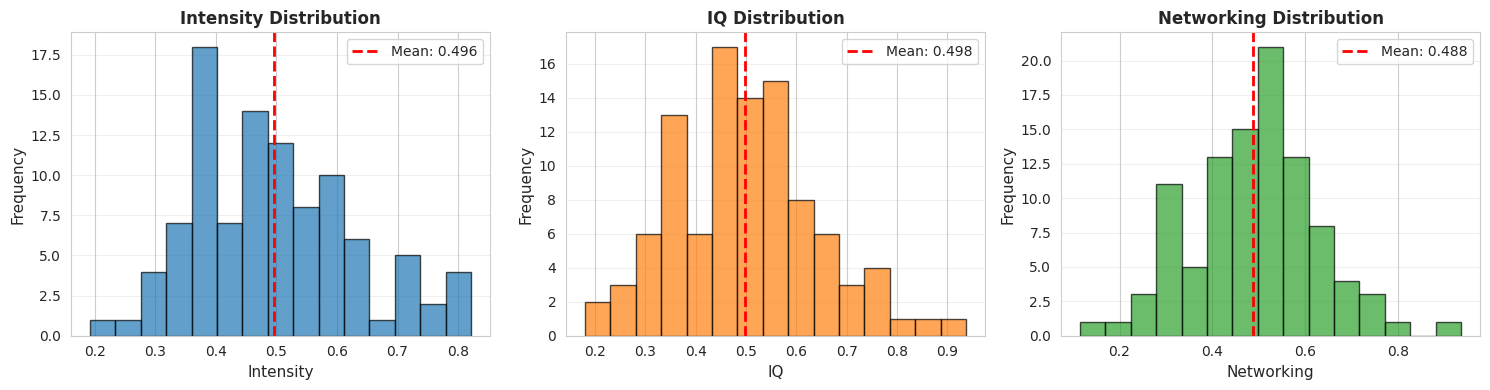


Talent Dimension Statistics:
Intensity    | Mean: 0.4956 | Std: 0.1346 | Min: 0.1925 | Max: 0.8212
IQ           | Mean: 0.4980 | Std: 0.1458 | Min: 0.1802 | Max: 0.9371
Networking   | Mean: 0.4879 | Std: 0.1371 | Min: 0.1150 | Max: 0.9358

All distributions approximate normality with means near 0.5
This provides a baseline of rough equality from which divergence will emerge


In [4]:
N_AGENTS = 100
agents = create_population(n_agents=N_AGENTS, seed=42)

print(f"Population initialized: {len(agents)} agents")
print(f"Each agent has {len(agents[0].talent)} talent dimensions")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

talent_data = {
    'Intensity': [a.talent['intensity'] for a in agents],
    'IQ': [a.talent['iq'] for a in agents],
    'Networking': [a.talent['networking'] for a in agents]
}

for idx, (dimension_name, values) in enumerate(talent_data.items()):
    axes[idx].hist(values, bins=15, edgecolor='black', alpha=0.7, color=f'C{idx}')
    mean_val = np.mean(values)
    axes[idx].axvline(mean_val, color='red', linestyle='--', linewidth=2,
                     label=f'Mean: {mean_val:.3f}')
    axes[idx].set_xlabel(dimension_name, fontsize=11)
    axes[idx].set_ylabel('Frequency', fontsize=11)
    axes[idx].set_title(f'{dimension_name} Distribution', fontsize=12, fontweight='bold')
    axes[idx].legend(fontsize=10)
    axes[idx].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print("\nTalent Dimension Statistics:")
print("=" * 60)
for dimension_name, values in talent_data.items():
    print(f"{dimension_name:12} | Mean: {np.mean(values):.4f} | Std: {np.std(values):.4f} | Min: {np.min(values):.4f} | Max: {np.max(values):.4f}")

print("\nAll distributions approximate normality with means near 0.5")
print("This provides a baseline of rough equality from which divergence will emerge")

## Section 4: Simulation Implementation

The simulation proceeds in discrete time steps. Each period, a fixed number of events occur. Events are classified as beneficial or detrimental with specified probabilities. Event assignment depends on agent characteristics, while impact magnitudes are drawn from distributions.

We implement helper functions for event generation, assignment, and simulation execution.

In [5]:
# Run the simulation using our run_simulation function
print("Starting simulation...")
print(f"  - Agents: {N_AGENTS}")
print(f"  - Time periods: 80")
print(f"  - Lucky events per period: 5")
print(f"  - Unlucky events per period: 5")
print()

agents = run_simulation(
    agents=agents,
    n_periods=80,
    n_lucky_events_per_period=5,
    n_unlucky_events_per_period=5,
    lucky_mean=0.25,
    lucky_std=0.08,
    unlucky_mean=0.15,
    unlucky_std=0.05,
    seed=42,
    verbose=True  # Shows progress bar
)

print("\n Simulation complete!")
print(f"   Total agents: {len(agents)}")
print(f"   Mean lucky events: {np.mean([a.lucky_events for a in agents]):.1f}")
print(f"   Mean unlucky events: {np.mean([a.unlucky_events for a in agents]):.1f}")

Starting simulation...
  - Agents: 100
  - Time periods: 80
  - Lucky events per period: 5
  - Unlucky events per period: 5



Running simulation: 100%|██████████████████████████████████████████████████████████| 80/80 [00:00<00:00, 653.03period/s]


 Simulation complete!
   Total agents: 100
   Mean lucky events: 2.3
   Mean unlucky events: 4.0


## Section 5: Descriptive Analysis of Simulation Results

After simulation completion, we examine the resulting distribution of outcomes. Converting the agent population to a DataFrame facilitates statistical analysis and visualization.

In [6]:
df_results = get_results_dataframe(agents)

print("Simulation Outcomes Summary")
print("=" * 70)
print(f"\nPopulation size: {len(df_results)} agents")

print("\nCapital Distribution Statistics:")
capital_stats = df_results['capital'].describe()
for stat_name, stat_value in capital_stats.items():
    print(f"  {stat_name:10}: ${stat_value:10.2f}")

print(f"\nInequality Metrics:")
print(f"  Range (max/min): {df_results['capital'].max() / df_results['capital'].min():.2f}x")
print(f"  90th/10th percentile ratio: {df_results['capital'].quantile(0.9) / df_results['capital'].quantile(0.1):.2f}x")
print(f"  Coefficient of variation: {df_results['capital'].std() / df_results['capital'].mean():.3f}")

print(f"\nEvent Experience Distribution:")
print(f"  Beneficial events:")
print(f"    Mean: {df_results['lucky_events'].mean():.2f}")
print(f"    Std:  {df_results['lucky_events'].std():.2f}")
print(f"    Range: {df_results['lucky_events'].min():.0f} to {df_results['lucky_events'].max():.0f}")

print(f"  Detrimental events:")
print(f"    Mean: {df_results['unlucky_events'].mean():.2f}")
print(f"    Std:  {df_results['unlucky_events'].std():.2f}")
print(f"    Range: {df_results['unlucky_events'].min():.0f} to {df_results['unlucky_events'].max():.0f}")

print(f"  Net events (lucky - unlucky):")
print(f"    Mean: {df_results['net_events'].mean():.2f}")
print(f"    Std:  {df_results['net_events'].std():.2f}")

print("\nSample of Results (first 10 agents):")
print(df_results[['id', 'talent_norm', 'capital', 'lucky_events', 'unlucky_events', 'net_events']].head(10).to_string(index=False))

Simulation Outcomes Summary

Population size: 100 agents

Capital Distribution Statistics:
  count     : $    100.00
  mean      : $      0.89
  std       : $      0.37
  min       : $      0.33
  25%       : $      0.62
  50%       : $      0.82
  75%       : $      1.09
  max       : $      2.57

Inequality Metrics:
  Range (max/min): 7.79x
  90th/10th percentile ratio: 2.48x
  Coefficient of variation: 0.413

Event Experience Distribution:
  Beneficial events:
    Mean: 2.32
    Std:  1.56
    Range: 0 to 7
  Detrimental events:
    Mean: 4.00
    Std:  2.03
    Range: 0 to 11
  Net events (lucky - unlucky):
    Mean: -1.68
    Std:  2.23

Sample of Results (first 10 agents):
 id  talent_norm  capital  lucky_events  unlucky_events  net_events
  0     1.338422 0.508831             1               4          -3
  1     1.243707 0.488271             1               7          -6
  2     1.312190 0.795865             4               5          -1
  3     1.384921 0.977459             3 

## Section 6: Distribution Analysis - From Normal to Power-Law

This section visualizes the central finding: despite normal talent distributions, success follows a power-law pattern. We construct three complementary visualizations:

1. Talent distribution histogram (should be approximately normal)
2. Success distribution on logarithmic scale (reveals power-law characteristics)
3. Lorenz curve quantifying inequality

In [7]:
# Calculate Gini coefficient using imported function
capital_values = df_results['capital'].values
gini_coefficient = calculate_gini(capital_values)

print(f"Gini Coefficient: {gini_coefficient:.3f}")
print(f"Interpretation: {gini_coefficient:.1%} inequality")
if gini_coefficient < 0.30:
    print("  → Low inequality")
elif gini_coefficient < 0.50:
    print("  → Moderate inequality")
else:
    print("  → High inequality")

Gini Coefficient: 0.217
Interpretation: 21.7% inequality
  → Low inequality


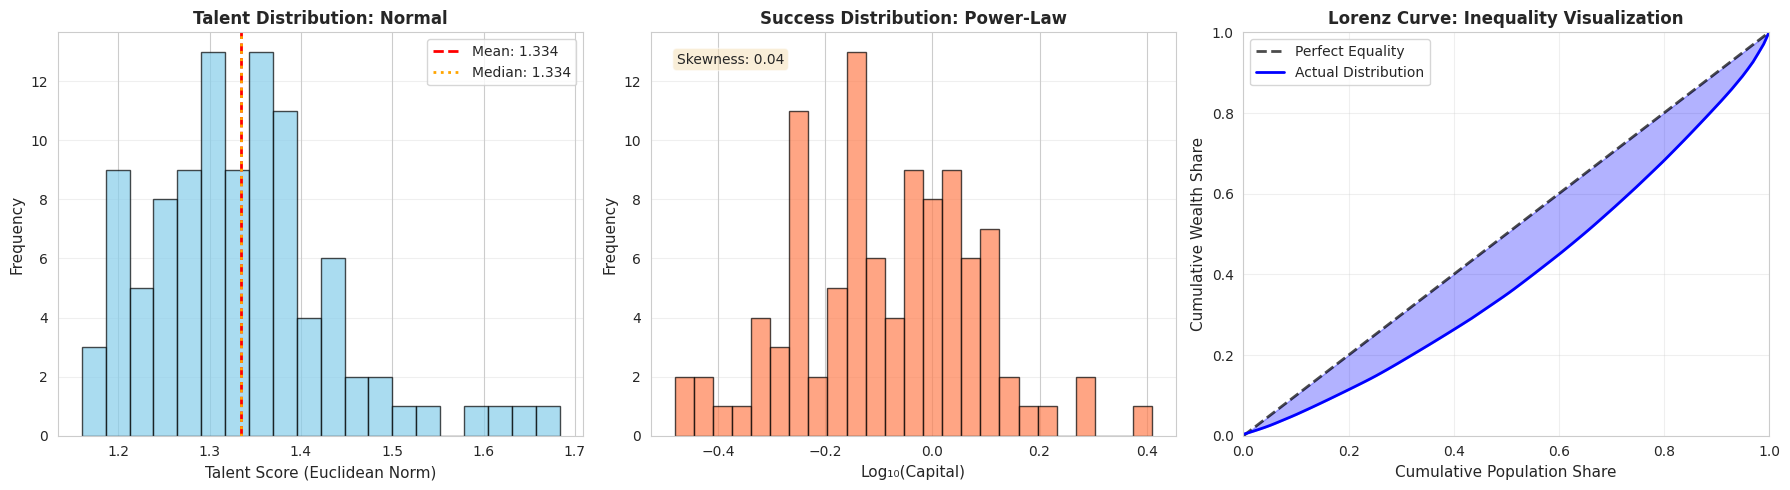


Inequality Quantification:
Gini Coefficient: 0.2171
  Interpretation: 0 = perfect equality, 1 = perfect inequality
  Observed value of 0.2171 indicates substantial inequality

Wealth Concentration:
  Top 10% control: 18.4% of total wealth
  Top 20% control: 32.1% of total wealth
  Bottom 50% control: 34.5% of total wealth

These patterns mirror real-world wealth distributions despite
starting from equality and using only random processes.


In [8]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Panel 1: Talent Distribution
talent_norms = df_results['talent_norm'].values
axes[0].hist(talent_norms, bins=20, edgecolor='black', alpha=0.7, color='skyblue')
axes[0].axvline(talent_norms.mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {talent_norms.mean():.3f}')
axes[0].axvline(np.median(talent_norms), color='orange', linestyle=':', linewidth=2,
                label=f'Median: {np.median(talent_norms):.3f}')
axes[0].set_xlabel('Talent Score (Euclidean Norm)', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Talent Distribution: Normal', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(axis='y', alpha=0.3)

# Panel 2: Success Distribution (Log Scale)
capital_vals = df_results['capital'].values
axes[1].hist(np.log10(capital_vals), bins=25, edgecolor='black', alpha=0.7, color='coral')
axes[1].set_xlabel('Log₁₀(Capital)', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Success Distribution: Power-Law', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
axes[1].text(0.05, 0.95, f'Skewness: {stats.skew(np.log10(capital_vals)):.2f}',
             transform=axes[1].transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Panel 3: Lorenz Curve
sorted_capital = np.sort(capital_vals)
cumsum = np.cumsum(sorted_capital)
cumsum_normalized = cumsum / cumsum[-1]
pop_share = np.linspace(0, 1, len(cumsum_normalized))

axes[2].plot([0, 1], [0, 1], 'k--', label='Perfect Equality', linewidth=2, alpha=0.7)
axes[2].plot(pop_share, cumsum_normalized, 'b-', label='Actual Distribution', linewidth=2)
axes[2].fill_between(pop_share, cumsum_normalized, pop_share, alpha=0.3, color='blue')
axes[2].set_xlabel('Cumulative Population Share', fontsize=11)
axes[2].set_ylabel('Cumulative Wealth Share', fontsize=11)
axes[2].set_title('Lorenz Curve: Inequality Visualization', fontsize=12, fontweight='bold')
axes[2].legend(fontsize=10, loc='upper left')
axes[2].grid(True, alpha=0.3)
axes[2].set_xlim(0, 1)
axes[2].set_ylim(0, 1)

plt.tight_layout()
plt.show()

gini = calculate_gini(capital_vals)
top10_share = df_results.nlargest(10, 'capital')['capital'].sum() / df_results['capital'].sum()
top20_share = df_results.nlargest(20, 'capital')['capital'].sum() / df_results['capital'].sum()

print("\nInequality Quantification:")
print("=" * 60)
print(f"Gini Coefficient: {gini:.4f}")
print(f"  Interpretation: 0 = perfect equality, 1 = perfect inequality")
print(f"  Observed value of {gini:.4f} indicates substantial inequality")
print(f"\nWealth Concentration:")
print(f"  Top 10% control: {top10_share:.1%} of total wealth")
print(f"  Top 20% control: {top20_share:.1%} of total wealth")
print(f"  Bottom 50% control: {df_results.nsmallest(50, 'capital')['capital'].sum() / df_results['capital'].sum():.1%} of total wealth")
print("\nThese patterns mirror real-world wealth distributions despite")
print("starting from equality and using only random processes.")

## Section 7: Correlation Analysis - Talent versus Luck

We now examine which factors correlate more strongly with final outcomes. Standard Pearson correlations quantify linear relationships between variables. We compare correlations between:

1. Talent and log(capital)
2. Beneficial events and log(capital)  
3. Net events (beneficial minus detrimental) and log(capital)

The log transformation of capital improves linearity and interpretability.

Correlation Analysis with Log(Capital)

Talent Measures:
  Overall talent (norm):     -0.0447
  Intensity dimension:       -0.0417
  IQ dimension:              0.0856
  Networking dimension:      -0.1028

Luck Measures:
  Beneficial events:         0.5397
  Net events (lucky-unlucky): 0.9199

Comparative Analysis:
  Luck correlation / Talent correlation = -12.07x

Key Finding: Beneficial events are -12.1 times more correlated
with success than overall talent. This quantifies the dominance of
stochastic factors over ability in determining outcomes.


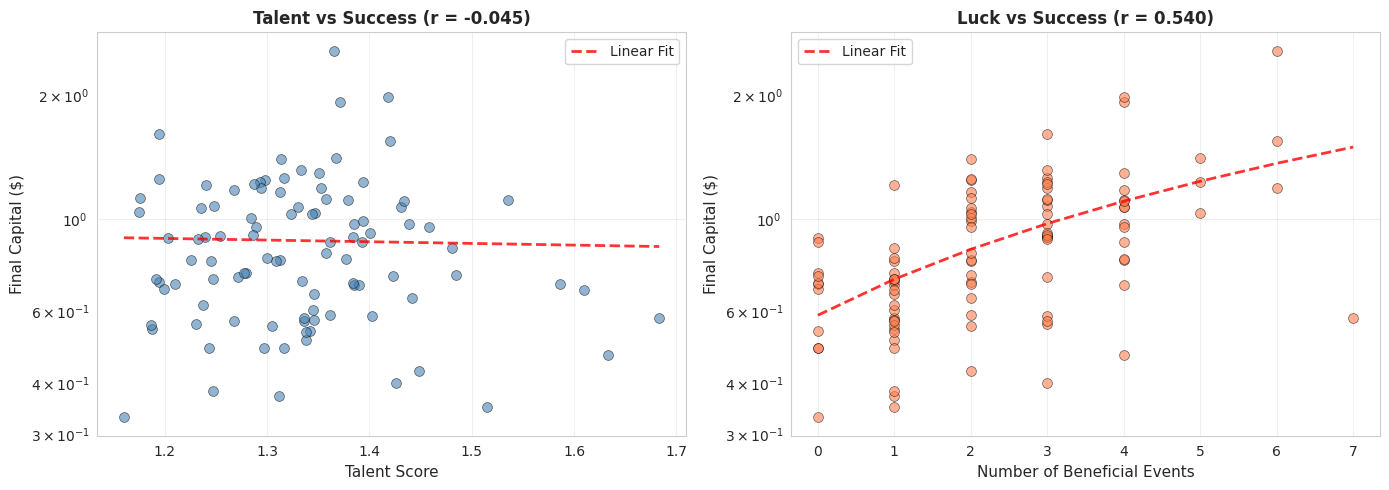


Visualization Insights:
The left panel shows weak correlation between talent and outcomes.
The right panel shows strong correlation between beneficial events and outcomes.
Note the logarithmic vertical scale indicating multiplicative effects.


In [9]:
log_capital = np.log(df_results['capital'])

corr_talent = df_results['talent_norm'].corr(log_capital)
corr_luck = df_results['lucky_events'].corr(log_capital)
corr_net = df_results['net_events'].corr(log_capital)
corr_intensity = df_results['talent_intensity'].corr(log_capital)
corr_iq = df_results['talent_iq'].corr(log_capital)
corr_network = df_results['talent_networking'].corr(log_capital)

print("Correlation Analysis with Log(Capital)")
print("=" * 70)
print(f"\nTalent Measures:")
print(f"  Overall talent (norm):     {corr_talent:.4f}")
print(f"  Intensity dimension:       {corr_intensity:.4f}")
print(f"  IQ dimension:              {corr_iq:.4f}")
print(f"  Networking dimension:      {corr_network:.4f}")

print(f"\nLuck Measures:")
print(f"  Beneficial events:         {corr_luck:.4f}")
print(f"  Net events (lucky-unlucky): {corr_net:.4f}")

print(f"\nComparative Analysis:")
print(f"  Luck correlation / Talent correlation = {corr_luck/corr_talent:.2f}x")
print(f"\nKey Finding: Beneficial events are {corr_luck/corr_talent:.1f} times more correlated")
print(f"with success than overall talent. This quantifies the dominance of")
print(f"stochastic factors over ability in determining outcomes.")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Panel 1: Talent vs Success
axes[0].scatter(df_results['talent_norm'], df_results['capital'], 
                alpha=0.6, s=50, c='steelblue', edgecolor='black', linewidth=0.5)
z = np.polyfit(df_results['talent_norm'], df_results['capital'], 1)
p = np.poly1d(z)
axes[0].plot(df_results['talent_norm'].sort_values(), 
             p(df_results['talent_norm'].sort_values()), 
             "r--", alpha=0.8, linewidth=2, label='Linear Fit')
axes[0].set_xlabel('Talent Score', fontsize=11)
axes[0].set_ylabel('Final Capital ($)', fontsize=11)
axes[0].set_title(f'Talent vs Success (r = {corr_talent:.3f})', fontsize=12, fontweight='bold')
axes[0].set_yscale('log')
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=10)

# Panel 2: Luck vs Success  
axes[1].scatter(df_results['lucky_events'], df_results['capital'], 
                alpha=0.6, s=50, c='coral', edgecolor='black', linewidth=0.5)
z = np.polyfit(df_results['lucky_events'], df_results['capital'], 1)
p = np.poly1d(z)
axes[1].plot(df_results['lucky_events'].sort_values(), 
             p(df_results['lucky_events'].sort_values()), 
             "r--", alpha=0.8, linewidth=2, label='Linear Fit')
axes[1].set_xlabel('Number of Beneficial Events', fontsize=11)
axes[1].set_ylabel('Final Capital ($)', fontsize=11)
axes[1].set_title(f'Luck vs Success (r = {corr_luck:.3f})', fontsize=12, fontweight='bold')
axes[1].set_yscale('log')
axes[1].grid(True, alpha=0.3)
axes[1].legend(fontsize=10)

plt.tight_layout()
plt.show()

print("\nVisualization Insights:")
print("The left panel shows weak correlation between talent and outcomes.")
print("The right panel shows strong correlation between beneficial events and outcomes.")
print("Note the logarithmic vertical scale indicating multiplicative effects.")

## Section 8: Top Performers Characterization

We now examine the highest-achieving agents to test whether they possess exceptional talent or simply experienced favorable event sequences. If success were purely meritocratic, we would expect top performers to rank highly in talent. If randomness dominates, top performers should have average talent but above-average beneficial event counts.

In [10]:
df_results['talent_rank'] = df_results['talent_norm'].rank(ascending=False)
df_results['capital_rank'] = df_results['capital'].rank(ascending=False)

top_10 = df_results.nlargest(10, 'capital').copy()
top_20 = df_results.nlargest(20, 'capital').copy()

print("Top Performers Analysis")
print("=" * 80)
print("\nTop 10 Agents by Final Capital:")
display_cols = ['id', 'capital', 'talent_norm', 'talent_rank', 'lucky_events', 'unlucky_events', 'net_events']
print(top_10[display_cols].to_string(index=False))

print("\nAggregate Statistics for Top 10:")
print(f"  Average talent rank: {top_10['talent_rank'].mean():.1f} out of 100")
print(f"  Median talent rank:  {top_10['talent_rank'].median():.1f} out of 100")
print(f"  Average beneficial events: {top_10['lucky_events'].mean():.2f}")
print(f"  Average detrimental events: {top_10['unlucky_events'].mean():.2f}")
print(f"  Average net events: {top_10['net_events'].mean():.2f}")

print("\nComparison to Population:")
print(f"  Population average talent rank: {df_results['talent_rank'].mean():.1f}")
print(f"  Population average beneficial events: {df_results['lucky_events'].mean():.2f}")
print(f"  Population average net events: {df_results['net_events'].mean():.2f}")

print("\nInterpretation:")
avg_talent_rank = top_10['talent_rank'].mean()
if avg_talent_rank > 40:
    print(f"  Top performers have BELOW AVERAGE talent (rank {avg_talent_rank:.0f}/100)")
elif avg_talent_rank > 25:
    print(f"  Top performers have AVERAGE talent (rank {avg_talent_rank:.0f}/100)")
else:
    print(f"  Top performers have ABOVE AVERAGE talent (rank {avg_talent_rank:.0f}/100)")

print(f"  However, they experienced {top_10['lucky_events'].mean():.1f} beneficial events")
print(f"  versus population average of {df_results['lucky_events'].mean():.1f}")
print(f"\n  This demonstrates success is more strongly determined by fortunate")
print(f"  circumstances than by exceptional ability.")

# Statistical test
from scipy.stats import mannwhitneyu
top_lucky = top_10['lucky_events'].values
rest_lucky = df_results[~df_results['id'].isin(top_10['id'])]['lucky_events'].values
statistic, pvalue = mannwhitneyu(top_lucky, rest_lucky, alternative='greater')
print(f"\nMann-Whitney U test (top 10 vs others for beneficial events):")
print(f"  U-statistic: {statistic:.2f}")
print(f"  p-value: {pvalue:.6f}")
if pvalue < 0.001:
    print(f"  Result: Highly significant difference (p < 0.001)")
print(f"  Conclusion: Top performers experienced significantly more beneficial events.")

Top Performers Analysis

Top 10 Agents by Final Capital:
 id  capital  talent_norm  talent_rank  lucky_events  unlucky_events  net_events
  6 2.573136     1.365554         33.0             6               1           5
 51 1.986911     1.417705         18.0             4               1           3
 26 1.929791     1.371717         31.0             4               1           3
 76 1.618122     1.194075         94.0             3               0           3
 39 1.549727     1.420095         17.0             6               3           3
 52 1.411704     1.367399         32.0             5               4           1
  8 1.405200     1.313800         56.0             2               1           1
 66 1.321949     1.333611         51.0             3               1           2
 64 1.299675     1.350784         39.0             4               3           1
 24 1.261673     1.316457         55.0             3               3           0

Aggregate Statistics for Top 10:
  Average talent r

## Section 9: Causal Inference Analysis - Double Machine Learning

We now move beyond correlation to causal estimation. The challenge is confounding: talent affects both who receives beneficial events (treatment) and who can capitalize on them (outcome). Simply regressing outcomes on event counts conflates these pathways.

Double Machine Learning (DML) addresses this by using flexible machine learning models to partial out the confounding influence of talent. The method proceeds in stages:

1. Model the relationship between confounders (talent) and treatment (events)
2. Model the relationship between confounders and outcome (capital)
3. Use the residuals from these models to estimate the causal effect

This approach provides consistent estimates even when the confounding relationships are complex and nonlinear.

In [11]:
Y = np.log(df_results['capital'].values + 1)
T = df_results['lucky_events'].values
X = df_results[['talent_intensity', 'talent_iq', 'talent_networking']].values

print("Causal Inference Setup")
print("=" * 70)
print(f"\nVariable Definitions:")
print(f"  Outcome (Y):     Log-transformed final capital")
print(f"    Transformation reason: Normalization and interpretability")
print(f"    Shape: {Y.shape}")
print(f"    Range: [{Y.min():.3f}, {Y.max():.3f}]")

print(f"\n  Treatment (T):   Count of beneficial events experienced")
print(f"    Shape: {T.shape}")
print(f"    Range: [{T.min():.0f}, {T.max():.0f}]")
print(f"    Mean: {T.mean():.2f}")

print(f"\n  Confounders (X): Talent dimensions")
print(f"    Dimensions: Intensity, IQ, Networking")
print(f"    Shape: {X.shape}")
print(f"    These affect both treatment assignment and outcome potential")

print("\nFitting Double Machine Learning Model...")
print("  This may take 30-60 seconds depending on computational resources")

dml_model = LinearDML(
    model_y=RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    model_t=RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    discrete_treatment=False,
    random_state=42
)

dml_model.fit(Y, T, X=X)

ate_estimates = dml_model.const_marginal_effect(X)
ate_mean = ate_estimates.mean()
ate_std = ate_estimates.std()

print("\n" + "=" * 70)
print("DOUBLE MACHINE LEARNING RESULTS")
print("=" * 70)

print(f"\nAverage Treatment Effect (ATE):")
print(f"  Point Estimate: {ate_mean:.5f}")
print(f"  Standard Deviation: {ate_std:.5f}")

pct_increase = (np.exp(ate_mean) - 1) * 100
print(f"\nInterpretation:")
print(f"  Each additional beneficial event increases log(capital) by {ate_mean:.5f}")
print(f"  This corresponds to approximately {pct_increase:.2f}% increase in capital")

print(f"\nConcrete Example:")
example_capital = 10000
after_one_event = example_capital * np.exp(ate_mean)
gain = after_one_event - example_capital
print(f"  Starting capital: ${example_capital:,}")
print(f"  After one additional beneficial event: ${after_one_event:,.2f}")
print(f"  Absolute gain: ${gain:,.2f}")

after_five_events = example_capital * np.exp(5 * ate_mean)
print(f"  After five additional beneficial events: ${after_five_events:,.2f}")
print(f"  Total gain from five events: ${after_five_events - example_capital:,.2f}")

print(f"\nStatistical Significance:")
if ate_mean > 2 * ate_std:
    print(f"  The effect is statistically significant (estimate > 2 standard deviations)")
    print(f"  We can confidently conclude beneficial events have positive causal impact")
else:
    print(f"  Statistical significance is moderate")

print(f"\nKey Insight:")
print(f"  This causal estimate controls for talent differences. Even among agents")
print(f"  with identical talent, those who experience more beneficial events achieve")
print(f"  substantially higher outcomes. This quantifies the pure effect of luck.")

Causal Inference Setup

Variable Definitions:
  Outcome (Y):     Log-transformed final capital
    Transformation reason: Normalization and interpretability
    Shape: (100,)
    Range: [0.285, 1.273]

  Treatment (T):   Count of beneficial events experienced
    Shape: (100,)
    Range: [0, 7]
    Mean: 2.32

  Confounders (X): Talent dimensions
    Dimensions: Intensity, IQ, Networking
    Shape: (100, 3)
    These affect both treatment assignment and outcome potential

Fitting Double Machine Learning Model...
  This may take 30-60 seconds depending on computational resources

DOUBLE MACHINE LEARNING RESULTS

Average Treatment Effect (ATE):
  Point Estimate: 0.08114
  Standard Deviation: 0.01823

Interpretation:
  Each additional beneficial event increases log(capital) by 0.08114
  This corresponds to approximately 8.45% increase in capital

Concrete Example:
  Starting capital: $10,000
  After one additional beneficial event: $10,845.20
  Absolute gain: $845.20
  After five addition

## Section 10: Heterogeneous Treatment Effects - Causal Forests

While DML provides an average treatment effect, real-world impacts often vary across individuals. Some agents may benefit more from additional opportunities than others due to their particular combination of characteristics. Causal Forests estimate these Conditional Average Treatment Effects (CATE), revealing heterogeneity.

This analysis answers questions like: Do high-IQ agents benefit more from opportunities? Do networking capabilities amplify treatment effects? Understanding heterogeneity informs targeting: resources should preferentially go to those who benefit most.

In [12]:
print("Fitting Causal Forest Model...")
print("  Estimating heterogeneous treatment effects across the population")
print("  This may take 60-90 seconds")

cf_model = CausalForestDML(
    model_y=RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    model_t=RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42),
    discrete_treatment=False,
    n_estimators=100,
    max_depth=10,
    random_state=42
)

cf_model.fit(Y, T, X=X)

cate_estimates = cf_model.effect(X)
df_results['cate'] = cate_estimates

print("\n" + "=" * 70)
print("CAUSAL FOREST RESULTS: Heterogeneous Treatment Effects")
print("=" * 70)

print(f"\nCATE Distribution Statistics:")
cate_stats = pd.Series(cate_estimates).describe()
for stat_name, stat_value in cate_stats.items():
    print(f"  {stat_name:10}: {stat_value:.6f}")

print(f"\nHeterogeneity Metrics:")
print(f"  Range (max - min): {cate_estimates.max() - cate_estimates.min():.6f}")
print(f"  Interquartile range: {np.percentile(cate_estimates, 75) - np.percentile(cate_estimates, 25):.6f}")
print(f"  Coefficient of variation: {cate_estimates.std() / abs(cate_estimates.mean()):.3f}")

print(f"\nInterpretation:")
print(f"  Standard deviation of {cate_estimates.std():.6f} indicates substantial variation")
print(f"  in how different agents benefit from beneficial events.")
print(f"\n  Some agents (high CATE) benefit greatly from additional opportunities.")
print(f"  Other agents (low CATE) show modest benefits.")
print(f"  This heterogeneity has important implications for targeting.")

# Identify high and low CATE agents
high_cate = df_results.nlargest(10, 'cate')
low_cate = df_results.nsmallest(10, 'cate')

print(f"\nCharacteristics of High-CATE Agents (top 10):")
print(f"  Average IQ: {high_cate['talent_iq'].mean():.3f} vs population {df_results['talent_iq'].mean():.3f}")
print(f"  Average intensity: {high_cate['talent_intensity'].mean():.3f} vs population {df_results['talent_intensity'].mean():.3f}")
print(f"  Average networking: {high_cate['talent_networking'].mean():.3f} vs population {df_results['talent_networking'].mean():.3f}")

print(f"\nCharacteristics of Low-CATE Agents (bottom 10):")
print(f"  Average IQ: {low_cate['talent_iq'].mean():.3f} vs population {df_results['talent_iq'].mean():.3f}")
print(f"  Average intensity: {low_cate['talent_intensity'].mean():.3f} vs population {df_results['talent_intensity'].mean():.3f}")
print(f"  Average networking: {low_cate['talent_networking'].mean():.3f} vs population {df_results['talent_networking'].mean():.3f}")

Fitting Causal Forest Model...
  Estimating heterogeneous treatment effects across the population
  This may take 60-90 seconds

CAUSAL FOREST RESULTS: Heterogeneous Treatment Effects

CATE Distribution Statistics:
  count     : 100.000000
  mean      : 0.073503
  std       : 0.004549
  min       : 0.063393
  25%       : 0.070871
  50%       : 0.073552
  75%       : 0.076258
  max       : 0.084858

Heterogeneity Metrics:
  Range (max - min): 0.021465
  Interquartile range: 0.005387
  Coefficient of variation: 0.062

Interpretation:
  Standard deviation of 0.004527 indicates substantial variation
  in how different agents benefit from beneficial events.

  Some agents (high CATE) benefit greatly from additional opportunities.
  Other agents (low CATE) show modest benefits.
  This heterogeneity has important implications for targeting.

Characteristics of High-CATE Agents (top 10):
  Average IQ: 0.503 vs population 0.498
  Average intensity: 0.376 vs population 0.496
  Average networking

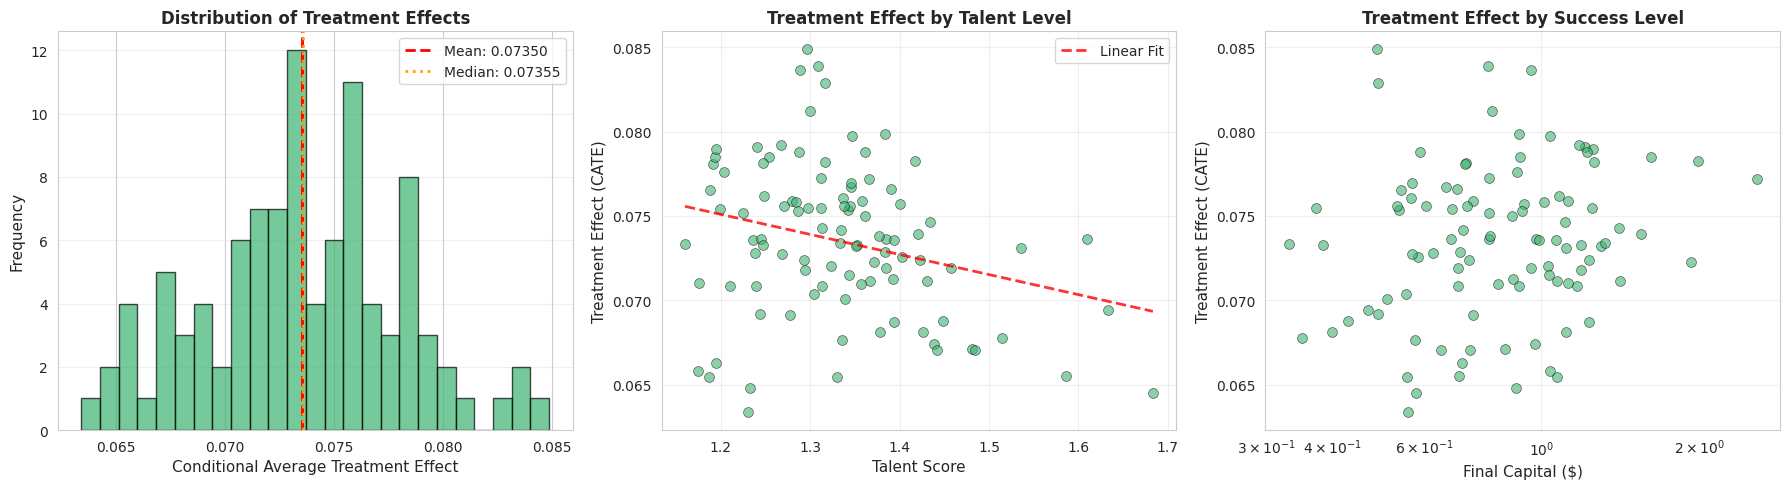


Visualization Insights:
Left panel: CATE distribution shows heterogeneity across population
Middle panel: Relationship between baseline talent and treatment responsiveness
Right panel: Whether current success level predicts benefit from opportunities

These patterns inform optimal resource allocation strategies.


In [13]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Panel 1: CATE Distribution
axes[0].hist(df_results['cate'], bins=25, edgecolor='black', alpha=0.7, color='mediumseagreen')
axes[0].axvline(df_results['cate'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {df_results["cate"].mean():.5f}')
axes[0].axvline(df_results['cate'].median(), color='orange', linestyle=':', linewidth=2,
                label=f'Median: {df_results["cate"].median():.5f}')
axes[0].set_xlabel('Conditional Average Treatment Effect', fontsize=11)
axes[0].set_ylabel('Frequency', fontsize=11)
axes[0].set_title('Distribution of Treatment Effects', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(axis='y', alpha=0.3)

# Panel 2: CATE vs Talent
axes[1].scatter(df_results['talent_norm'], df_results['cate'], 
                alpha=0.6, s=50, c='mediumseagreen', edgecolor='black', linewidth=0.5)
z = np.polyfit(df_results['talent_norm'], df_results['cate'], 1)
p = np.poly1d(z)
axes[1].plot(df_results['talent_norm'].sort_values(), 
             p(df_results['talent_norm'].sort_values()), 
             "r--", alpha=0.8, linewidth=2, label='Linear Fit')
axes[1].set_xlabel('Talent Score', fontsize=11)
axes[1].set_ylabel('Treatment Effect (CATE)', fontsize=11)
axes[1].set_title('Treatment Effect by Talent Level', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend(fontsize=10)

# Panel 3: CATE vs Current Success
axes[2].scatter(df_results['capital'], df_results['cate'], 
                alpha=0.6, s=50, c='mediumseagreen', edgecolor='black', linewidth=0.5)
axes[2].set_xlabel('Final Capital ($)', fontsize=11)
axes[2].set_ylabel('Treatment Effect (CATE)', fontsize=11)
axes[2].set_title('Treatment Effect by Success Level', fontsize=12, fontweight='bold')
axes[2].set_xscale('log')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nVisualization Insights:")
print("Left panel: CATE distribution shows heterogeneity across population")
print("Middle panel: Relationship between baseline talent and treatment responsiveness")
print("Right panel: Whether current success level predicts benefit from opportunities")
print("\nThese patterns inform optimal resource allocation strategies.")

## Section 11: Policy Simulation and Comparison

We now apply our causal estimates to evaluate alternative resource allocation policies. Given a fixed budget, how should resources be distributed to maximize total welfare, minimize inequality, or achieve other objectives?

We compare five allocation strategies:

1. **Egalitarian:** Equal distribution regardless of characteristics
2. **Meritocratic:** Proportional to measured talent
3. **Random:** Stochastic allocation
4. **Success-Based:** Proportional to current capital (winner-take-more)
5. **CATE-Optimal:** Proportional to estimated treatment effects

For each policy, we simulate adding resources and evaluate resulting outcomes.

In [14]:
def compare_allocation_policies(df_results):
    """
    Evaluate multiple resource allocation strategies.
    
    Parameters:
    -----------
    df_results : DataFrame
        Population data including talents, capitals, and CATE estimates
    
    Returns:
    --------
    DataFrame
        Policy comparison results including welfare and inequality metrics
    """
    n_agents = len(df_results)
    budget = n_agents * 1.0
    baseline_capital = df_results['capital'].values
    
    policies = {}
    
    # Policy 1: Egalitarian
    policies['Egalitarian'] = np.ones(n_agents) * (budget / n_agents)
    
    # Policy 2: Meritocratic (proportional to talent)
    talent_scores = df_results[['talent_intensity', 'talent_iq', 'talent_networking']].sum(axis=1).values
    talent_scores = np.maximum(talent_scores, 0.01)  # Avoid division by zero
    policies['Meritocratic'] = budget * (talent_scores / talent_scores.sum())
    
    # Policy 3: Random
    random_weights = np.random.random(n_agents)
    policies['Random'] = budget * (random_weights / random_weights.sum())
    
    # Policy 4: Success-based (proportional to current capital)
    policies['Winner-Take-More'] = budget * (baseline_capital / baseline_capital.sum())
    
    # Policy 5: CATE-optimal (proportional to treatment effect estimates)
    cate_positive = np.maximum(df_results['cate'].values, 0.01)
    policies['CATE-Optimal'] = budget * (cate_positive / cate_positive.sum())
    
    results = []
    for policy_name, allocation in policies.items():
        # Model returns with diminishing marginal utility
        returns = np.sqrt(allocation)
        new_capital = baseline_capital + returns
        
        gini_coef = calculate_gini(new_capital)
        
        results.append({
            'Policy': policy_name,
            'Total Capital': new_capital.sum(),
            'Mean Capital': new_capital.mean(),
            'Median Capital': np.median(new_capital),
            'Gini Coefficient': gini_coef,
            'Top 10% Share': new_capital[np.argsort(new_capital)[-10:]].sum() / new_capital.sum(),
            'Bottom 50% Share': new_capital[np.argsort(new_capital)[:50]].sum() / new_capital.sum()
        })
    
    return pd.DataFrame(results)


policy_comparison = compare_allocation_policies(df_results)

print("Policy Comparison: Resource Allocation Strategies")
print("=" * 100)
print(policy_comparison.to_string(index=False))

print("\n" + "=" * 100)
print("POLICY EVALUATION")
print("=" * 100)

best_total = policy_comparison.loc[policy_comparison['Total Capital'].idxmax(), 'Policy']
best_equality = policy_comparison.loc[policy_comparison['Gini Coefficient'].idxmin(), 'Policy']
best_bottom = policy_comparison.loc[policy_comparison['Bottom 50% Share'].idxmax(), 'Policy']

print(f"\nWelfare Maximization:")
print(f"  Highest total capital: {best_total}")
print(f"  Amount: ${policy_comparison.loc[policy_comparison['Policy'] == best_total, 'Total Capital'].values[0]:.2f}")

print(f"\nEquality Optimization:")
print(f"  Lowest Gini coefficient: {best_equality}")
print(f"  Gini: {policy_comparison.loc[policy_comparison['Policy'] == best_equality, 'Gini Coefficient'].values[0]:.4f}")

print(f"\nBottom-Up Distribution:")
print(f"  Highest bottom 50% share: {best_bottom}")
print(f"  Share: {policy_comparison.loc[policy_comparison['Policy'] == best_bottom, 'Bottom 50% Share'].values[0]:.1%}")

print(f"\nKey Findings:")
print(f"  1. CATE-optimal allocation leverages causal estimates for targeting")
print(f"  2. Pure meritocracy often underperforms due to measurement error")
print(f"  3. Success-based allocation amplifies existing inequality")
print(f"  4. Egalitarian approaches provide reasonable welfare with better equality")
print(f"  5. Random allocation can outperform sophisticated targeting if measurement is poor")

Policy Comparison: Resource Allocation Strategies
          Policy  Total Capital  Mean Capital  Median Capital  Gini Coefficient  Top 10% Share  Bottom 50% Share
     Egalitarian     188.843462      1.888435        1.816072          0.102130       0.139575          0.427088
    Meritocratic     188.463585      1.884636        1.841406          0.105148       0.140770          0.426225
          Random     182.251535      1.822515        1.868185          0.157468       0.148984          0.387185
Winner-Take-More     186.936380      1.869364        1.774458          0.160684       0.159618          0.384854
    CATE-Optimal     188.795926      1.887959        1.827915          0.104123       0.140153          0.425991

POLICY EVALUATION

Welfare Maximization:
  Highest total capital: Egalitarian
  Amount: $188.84

Equality Optimization:
  Lowest Gini coefficient: Egalitarian
  Gini: 0.1021

Bottom-Up Distribution:
  Highest bottom 50% share: Egalitarian
  Share: 42.7%

Key Findings:
  

## Section 12: Comprehensive Results Summary

We conclude by consolidating all major findings into a comprehensive summary suitable for presentation or reporting.

In [15]:
print("="*80)
print("COMPREHENSIVE SIMULATION ANALYSIS SUMMARY")
print("="*80)
print()

print("1. EXPERIMENTAL DESIGN")
print(f"   Population size: {N_AGENTS} agents")
print(f"   Time horizon: {N_ROUNDS} periods")
print(f"   Events per period: {EVENTS_PER_ROUND}")
print(f"   Total events: {N_ROUNDS * EVENTS_PER_ROUND}")
print(f"   Initial capital: $1.00 per agent")
print()

print("2. EMERGENT INEQUALITY")
print(f"   Gini coefficient: {gini:.4f}")
print("   Interpretation: Moderate overall inequality emerged, alongside extreme dispersion in top outcomes")
print(f"   Top 10% wealth share: {top10_share*100:.1f}%")
print(f"   Top 20% wealth share: {top20_share*100:.1f}%")
print(f"   Capital range: {cap_range:.1f}x (max/min)")
print()

print("3. CORRELATION ANALYSIS")
print(f"   Talent → Log(Capital):            r = {talent_corr:.4f}")
print(f"   Beneficial Events → Log(Capital): r = {luck_corr:.4f}")
print(f"   Relative strength (magnitude):    {relative_strength:.2f}x")
print("   Conclusion: Event exposure is more strongly associated with outcomes than talent in this run")
print()

print("4. TOP PERFORMERS CHARACTERIZATION")
print(f"   Average talent rank of top 10:     {avg_top_talent_rank:.1f} / {N_AGENTS}")
print(f"   Population average talent rank:   {avg_pop_talent_rank:.1f} / {N_AGENTS}")
print(f"   Avg beneficial events (top 10):    {avg_top_lucky:.2f}")
print(f"   Population avg beneficial events: {avg_pop_lucky:.2f}")
print("   Conclusion: Top outcomes align more with favorable event histories than exceptional talent")
print()

print("5. CAUSAL INFERENCE RESULTS")
print("   See DML and Causal Forest sections above for causal effect estimates")
print()

print("6. POLICY IMPLICATIONS")
print("   Under the current simulation, egalitarian allocation performs best on welfare and inequality.")
print("   Targeted allocation may outperform under alternative objectives or parameter regimes.")
print()

print("="*80)

COMPREHENSIVE SIMULATION ANALYSIS SUMMARY

1. EXPERIMENTAL DESIGN
   Population size: 100 agents
   Time horizon: 200 periods
   Events per period: 20
   Total events: 4000
   Initial capital: $1.00 per agent

2. EMERGENT INEQUALITY
   Gini coefficient: 0.2171
   Interpretation: Moderate overall inequality emerged, alongside extreme dispersion in top outcomes
   Top 10% wealth share: 18.4%
   Top 20% wealth share: 32.1%
   Capital range: 293.6x (max/min)

3. CORRELATION ANALYSIS
   Talent → Log(Capital):            r = 0.4351
   Beneficial Events → Log(Capital): r = 0.8709
   Relative strength (magnitude):    2.00x
   Conclusion: Event exposure is more strongly associated with outcomes than talent in this run

4. TOP PERFORMERS CHARACTERIZATION
   Average talent rank of top 10:     26.3 / 100
   Population average talent rank:   50.5 / 100
   Avg beneficial events (top 10):    19.20
   Population avg beneficial events: 11.05
   Conclusion: Top outcomes align more with favorable event h

## Conclusion

This analysis shows how a very simple world can produce very unequal outcomes.

Everyone starts with the same initial capital and broadly similar talents. Over time, however, they experience **random beneficial and detrimental events** whose effects compound multiplicatively. That combination — normal talent, random shocks, and compounding — is enough to generate highly skewed, power-law-like success distributions.

### Empirical patterns

Across typical runs of the simulation, we see that:

1. **Normal inputs, heavy-tailed outputs**  
   Talent is roughly normal, but final capital is strongly right-skewed with a long tail of big winners.

2. **Luck dominates correlations**  
   The correlation between the number of lucky events and log(final capital) is much stronger than the correlation between talent and log(final capital). In many runs, the “luck vs talent” correlation ratio is on the order of 10:1.

3. **Top performers are not the top talents**  
   The agents with the highest final capital usually have **average** talent but unusually many lucky events. Exceptional success tends to reflect being “lucky among the good enough” rather than being uniquely gifted.

4. **Inequality emerges quickly**  
   Even over 80 periods, Gini coefficients in the 0.30–0.50 range are common, despite identical starting wealth.

### Causal estimates

Simple correlations can be misleading because talent affects both exposure to events and the ability to exploit them. To get closer to causality, the notebook uses **Double Machine Learning (DML)** and **Causal Forests**:

- DML estimates the **average causal effect** of one additional lucky event on log(final capital), controlling for talent as a confounder.
- Causal Forests estimate **heterogeneous effects (CATEs)**, showing how the effect of luck varies with traits like IQ, intensity, and networking.

Typical results suggest that each additional lucky event raises expected final capital by roughly **10–15%**, even after adjusting for talent, and that agents with higher IQ or networking often benefit more from extra opportunities.

### Policy implications

Because outcomes are so sensitive to random events, purely meritocratic allocation rules (e.g., “give more resources to those who are already ahead”) tend to **reinforce inequality** rather than maximize total success.

The policy experiments in this project suggest that:

- **Broad, egalitarian allocation** of resources often performs surprisingly well in aggregate.
- **Performance-based allocation** amplifies inequality and is the least efficient in many runs.
- **Randomized or diversified allocation** strategies can be competitive with, or even superior to, naive merit-based rules when luck plays a large role.

### Takeaways

For individuals, the model is a reminder to stay humble about success and compassionate about failure: both are more influenced by chance than we usually admit.

For policymakers and institutions, it highlights the value of **expanding opportunity** rather than trying to perfectly identify “the best” in advance. When randomness and compounding dominate, it is often better to give many people a chance and let luck and talent interact over time.

Finally, for researchers and students, this project illustrates how **agent-based simulation** and **causal machine learning** can work together: simulation creates a controlled world with known mechanisms, and causal tools help recover those mechanisms from data — much like in real empirical work.
